# Neural Network for Time-Series Forecasting


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from models import NN

In [3]:


# Example Usage

input_dim = 1
output_dim = 1
state_dim = 1
hidden_dims = [16, 16]

model = NN(input_dim, hidden_dims, output_dim)

# Example data
batch_size = 1
state = torch.randn(batch_size, state_dim)
input = torch.randn(batch_size, input_dim)
observation_target = torch.randn(batch_size, output_dim)

from torchinfo import summary
print(summary(model, input_data=[state, input]))

# Forward pass
next_state, observation = model(state, input)

# loss
criterion = nn.MSELoss()
loss = criterion(next_state, state) + criterion(observation, observation_target)

print("Next State:", next_state)
print("Observation:", observation)
print("Loss:", loss.item())

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []

# Harmonic Oscillator

In [4]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Damped harmonic oscillator function
def oscillator(d, w0, t):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem."""
    assert d < w0
    d, w0 = torch.Tensor([d]), torch.Tensor([w0])
    w = torch.sqrt(w0**2 - d**2)
    phi = torch.arctan(-d/w)
    A = 1/(2*torch.cos(phi))
    cos = torch.cos(phi + w*t)
    exp = torch.exp(-d*t)
    x = exp * 2 * A * cos
    return x

# Function to generate oscillator data with given parameters
def generate_oscillator_data(seq_length, num_sequences, d, w0, start_time=0):
    t = torch.linspace(start_time, start_time + seq_length//100, seq_length)  # Adjust time scaling as needed
    data = oscillator(d, w0, t).unsqueeze(-1)
    sequences = data.repeat(num_sequences, 1, 1).reshape(num_sequences, seq_length, 1)
    times = t.repeat(num_sequences, 1, 1).reshape(num_sequences, seq_length, 1)
    return sequences, times


In [5]:

# Plotting functions
def plot_loss_curves(train_losses, test_losses, train_seq_length):
    train_losses = np.array(train_losses)
    test_losses = np.array(test_losses)
    
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(test_losses, label="Test Loss")
    plt.yscale('log')
    plt.title(f"Loss Curves for Train Seq Length {train_seq_length}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (Log Scale)")
    plt.legend()
    plt.show()


# Parameters
state_dim = 1
input_dim = 1
output_dim = 1
kan_layers = [64, 64]
batch_size = 1
num_sequences = 1
total_seq_length = 240
train_seq_lengths = [5, 10, 15, 20, 30, 60, 90, 120]  # Different lengths of training sequences

convergence_std_threshold = 1e-6  # Standard deviation threshold
patience_counter = 0
patience = 13  # Number of epochs with no improvement to wait before stopping
n_pts = 100


d, w0 = 4, 40

# Initialize performance data dictionary
performance_data = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for train_seq_length in train_seq_lengths:

    test_seq_length = total_seq_length - train_seq_length
    
    model = StateSpaceModel(state_dim, input_dim, output_dim, kan_layers).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    
    # Generate data
    total_data, total_times = generate_oscillator_data(total_seq_length, num_sequences, d, w0, start_time=0)
    total_data, total_times = total_data.to(device), total_times.to(device)
    
    # Split into train and test sets by non-overlapping time intervals
    train_data = total_data[:, :train_seq_length, :]
    train_times = total_times[:, :train_seq_length, :]
    test_data = total_data[:, train_seq_length:, :]
    test_times = total_times[:, train_seq_length:, :]
    

    train_losses = []
    test_losses = []
    best_loss = float('inf')
    patience_counter = 0
    
    epoch = 0
    while patience_counter < patience:
        model.train()
        optimizer.zero_grad()
        

        state = train_data # Training part of the sequence
        input = train_times  # Training part of the sequence (next state)
        observation_target = train_data
        
        state = state.reshape(-1, state_dim)
        input = input.reshape(-1, input_dim)
        observation_target = observation_target.reshape(-1, output_dim)
        
        next_state, observation = model(state, input)
        loss = criterion(next_state, state) + criterion(observation, observation_target)
        
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())

        # Check convergence criteria based on the standard deviation of the last few training losses
        if len(train_losses) > n_pts:
            recent_losses = train_losses[-n_pts:]
            std_recent_losses = np.std(recent_losses)
            if std_recent_losses < convergence_std_threshold:
                patience_counter += 1
            else:
                patience_counter = 0
        else:
            patience_counter = 0
        
        # Validation on test data
        model.eval()
        with torch.no_grad():
            # test_state = test_data[:, :train_seq_length-1, :]
            # test_input = test_times[:, 1:train_seq_length, :]

            test_state = test_data
            test_input = test_times
            
            test_state = test_state.reshape(-1, state_dim)
            test_input = test_input.reshape(-1, input_dim)
            
            _, test_observation = model(test_state, test_input)
            
            test_loss = criterion(test_observation, test_data.reshape(-1, output_dim))
            test_losses.append(test_loss.item())

        # if (epoch + 1) % 10 == 0:
        #     print(f"Train Seq Length {train_seq_length}, Epoch {epoch+1}, Train Loss: {loss.item():.3e}, Test Loss: {test_loss.item():.3e}")
        
        epoch += 1
    
    # Save performance data
    performance_data.append({
        "train_seq_length": train_seq_length,
        "final_train_loss": train_losses[-1],
        "final_test_loss": test_losses[-1]
    })
    
    # Plot loss curves
    plot_loss_curves(train_losses, test_losses, train_seq_length)

    
    plt.figure(figsize=(12, 6))
    trn_time_plt = train_times.reshape(-1, 1).cpu().numpy()
    tst_time_plt = test_times.reshape(-1, 1).cpu().numpy()

    trn_true_plt = train_data.reshape(-1, 1).cpu().numpy()
    tst_true_plt = test_data.reshape(-1, 1).cpu().numpy()

    trn_pred_plt = observation.reshape(-1, 1).detach().cpu().numpy()
    tst_pred_plt = test_observation.reshape(-1, 1).detach().cpu().numpy()

    vline = (trn_time_plt[-1]+tst_time_plt[0])/2

    plt.plot(trn_time_plt, trn_true_plt, color='black', linestyle='-', label="True")
    plt.plot(tst_time_plt, tst_true_plt, color='black', linestyle='-')

    plt.plot(trn_time_plt, trn_pred_plt, color='red', linestyle='--', label="Pred")
    plt.plot(tst_time_plt, tst_pred_plt, color='red', linestyle='--')

    plt.axvspan(0, vline[0], alpha=0.3, color='blue', label="Training Data")
    plt.axvspan(vline[0], tst_time_plt[-1][0], alpha=0.3, color='green', label="Testing Data")
    plt.axvline(vline, color='teal', linestyle='--')

    plt.legend()
    plt.show()

# Convert performance data to a DataFrame for seaborn plotting
performance_df = pd.DataFrame(performance_data)

plt.figure(figsize=(14, 8))
sns.barplot(x="train_seq_length", y="final_test_loss", data=performance_df)
plt.title("Final Test Loss for Different Train Lengths")
plt.yscale('log')
plt.xlabel("Train Sequence Length")
plt.ylabel("Final Test Loss (Log Scale)")
plt.show()




# Print performance data for inspection
for data in performance_data:
    print(f"Train Seq Length {data['train_seq_length']}:")
    print(f"  Final Train Loss: {data['final_train_loss']:.3e}")
    print(f"  Final Test Loss: {data['final_test_loss']:.3e}")

# Save performance data to a file if needed
import json
with open("performance_data.json", "w") as f:
    json.dump(performance_data, f)


NameError: name 'StateSpaceModel' is not defined

# Experimental Loop - (PI-){NN, KAN, KASSM}

Train Seq Length 10, Extrapolation Length 110, Epoch 10, Train Loss: 7.534e-01, Test Loss: 3.332e-01, Extrapolation Loss: 2.338e-02
Train Seq Length 10, Extrapolation Length 110, Epoch 20, Train Loss: 6.623e-01, Test Loss: 2.996e-01, Extrapolation Loss: 2.280e-02
Train Seq Length 10, Extrapolation Length 110, Epoch 30, Train Loss: 5.545e-01, Test Loss: 2.541e-01, Extrapolation Loss: 2.231e-02
Train Seq Length 10, Extrapolation Length 110, Epoch 40, Train Loss: 4.222e-01, Test Loss: 1.922e-01, Extrapolation Loss: 2.285e-02
Train Seq Length 10, Extrapolation Length 110, Epoch 50, Train Loss: 2.702e-01, Test Loss: 1.175e-01, Extrapolation Loss: 2.774e-02
Train Seq Length 10, Extrapolation Length 110, Epoch 60, Train Loss: 1.261e-01, Test Loss: 4.749e-02, Extrapolation Loss: 4.427e-02
Train Seq Length 10, Extrapolation Length 110, Epoch 70, Train Loss: 3.606e-02, Test Loss: 9.687e-03, Extrapolation Loss: 7.746e-02
Train Seq Length 10, Extrapolation Length 110, Epoch 80, Train Loss: 1.614e-

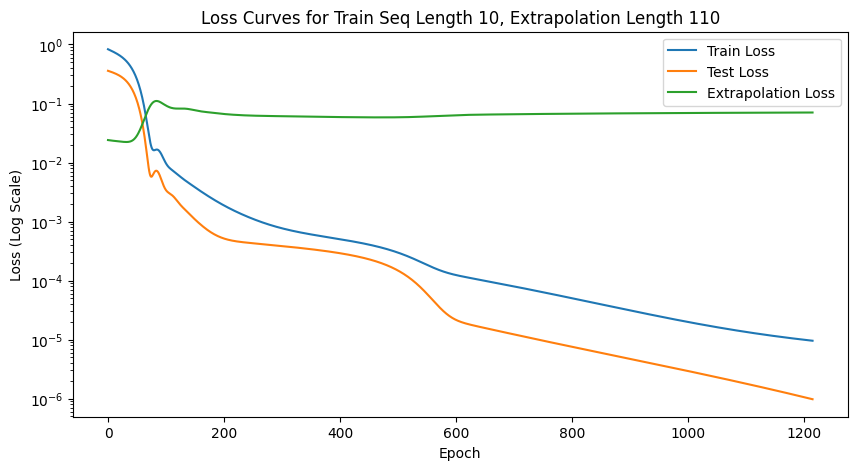

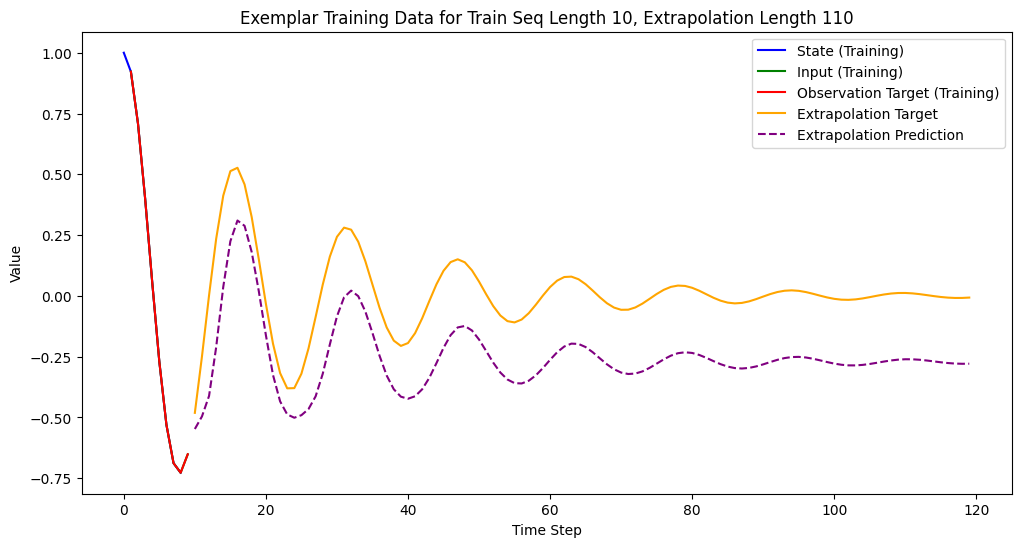

Train Seq Length 15, Extrapolation Length 105, Epoch 10, Train Loss: 5.589e-01, Test Loss: 2.442e-01, Extrapolation Loss: 1.833e-02
Train Seq Length 15, Extrapolation Length 105, Epoch 20, Train Loss: 4.920e-01, Test Loss: 2.118e-01, Extrapolation Loss: 1.620e-02
Train Seq Length 15, Extrapolation Length 105, Epoch 30, Train Loss: 4.085e-01, Test Loss: 1.708e-01, Extrapolation Loss: 1.334e-02
Train Seq Length 15, Extrapolation Length 105, Epoch 40, Train Loss: 3.031e-01, Test Loss: 1.192e-01, Extrapolation Loss: 9.343e-03
Train Seq Length 15, Extrapolation Length 105, Epoch 50, Train Loss: 1.846e-01, Test Loss: 6.431e-02, Extrapolation Loss: 5.379e-03
Train Seq Length 15, Extrapolation Length 105, Epoch 60, Train Loss: 8.495e-02, Test Loss: 2.562e-02, Extrapolation Loss: 4.752e-03
Train Seq Length 15, Extrapolation Length 105, Epoch 70, Train Loss: 3.970e-02, Test Loss: 1.602e-02, Extrapolation Loss: 9.108e-03
Train Seq Length 15, Extrapolation Length 105, Epoch 80, Train Loss: 3.204e-

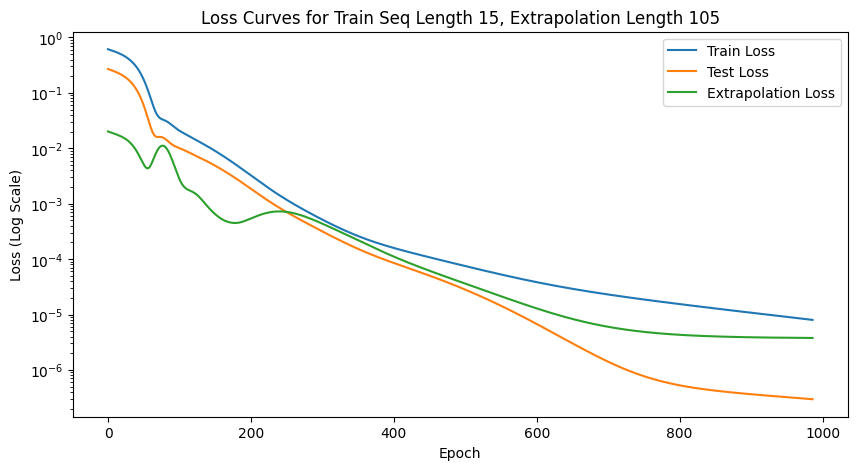

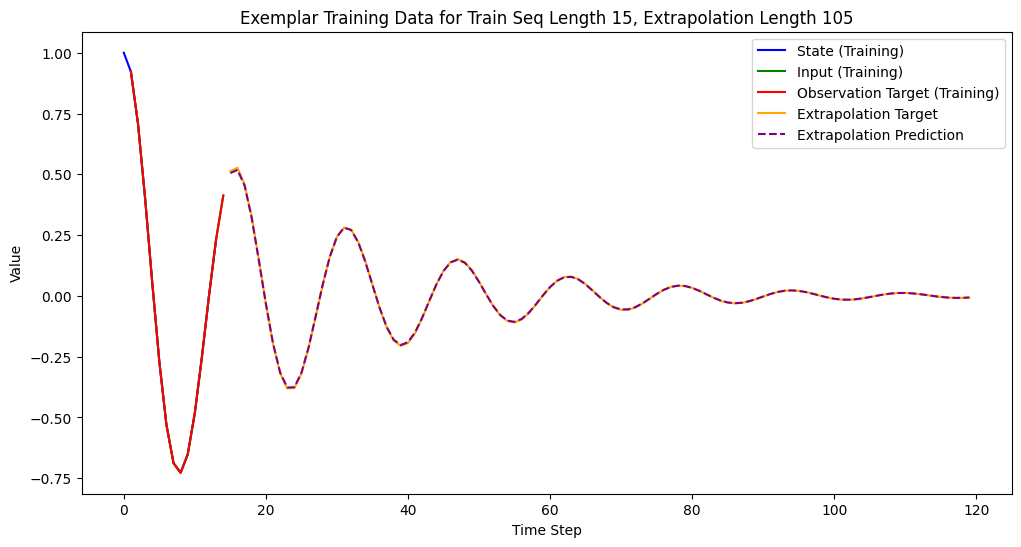

Train Seq Length 30, Extrapolation Length 90, Epoch 10, Train Loss: 3.551e-01, Test Loss: 1.662e-01, Extrapolation Loss: 6.421e-03
Train Seq Length 30, Extrapolation Length 90, Epoch 20, Train Loss: 3.148e-01, Test Loss: 1.450e-01, Extrapolation Loss: 5.674e-03
Train Seq Length 30, Extrapolation Length 90, Epoch 30, Train Loss: 2.615e-01, Test Loss: 1.181e-01, Extrapolation Loss: 4.657e-03
Train Seq Length 30, Extrapolation Length 90, Epoch 40, Train Loss: 1.911e-01, Test Loss: 8.405e-02, Extrapolation Loss: 3.354e-03
Train Seq Length 30, Extrapolation Length 90, Epoch 50, Train Loss: 1.099e-01, Test Loss: 4.696e-02, Extrapolation Loss: 2.087e-03
Train Seq Length 30, Extrapolation Length 90, Epoch 60, Train Loss: 4.367e-02, Test Loss: 2.010e-02, Extrapolation Loss: 1.720e-03
Train Seq Length 30, Extrapolation Length 90, Epoch 70, Train Loss: 2.104e-02, Test Loss: 1.350e-02, Extrapolation Loss: 2.241e-03
Train Seq Length 30, Extrapolation Length 90, Epoch 80, Train Loss: 2.094e-02, Test

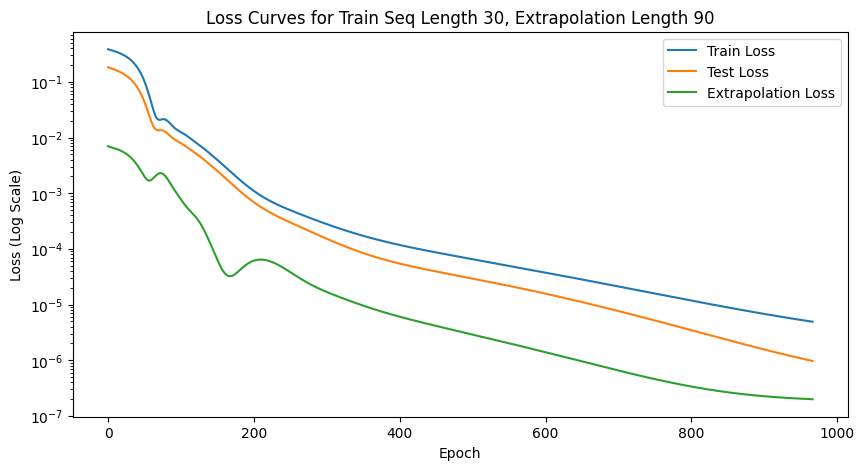

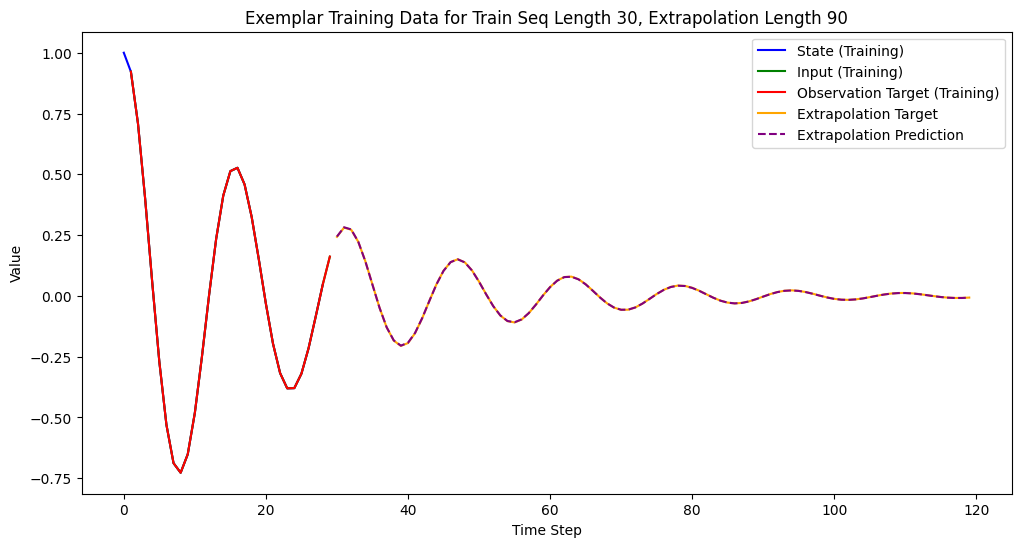

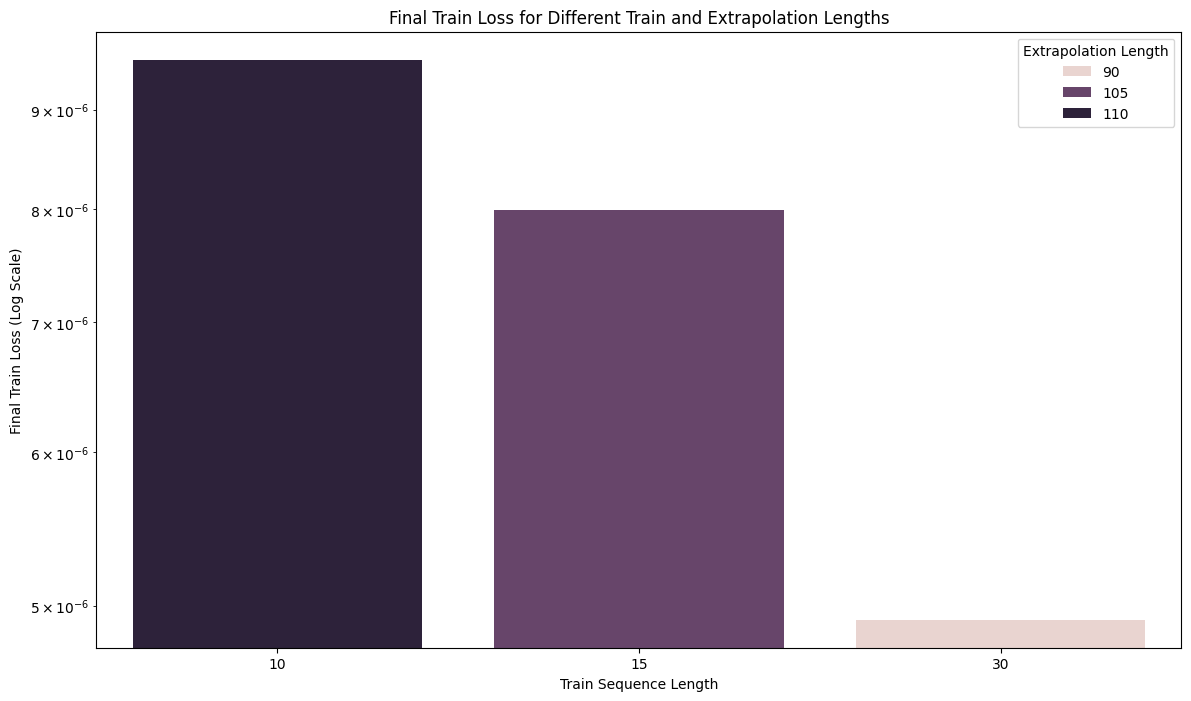

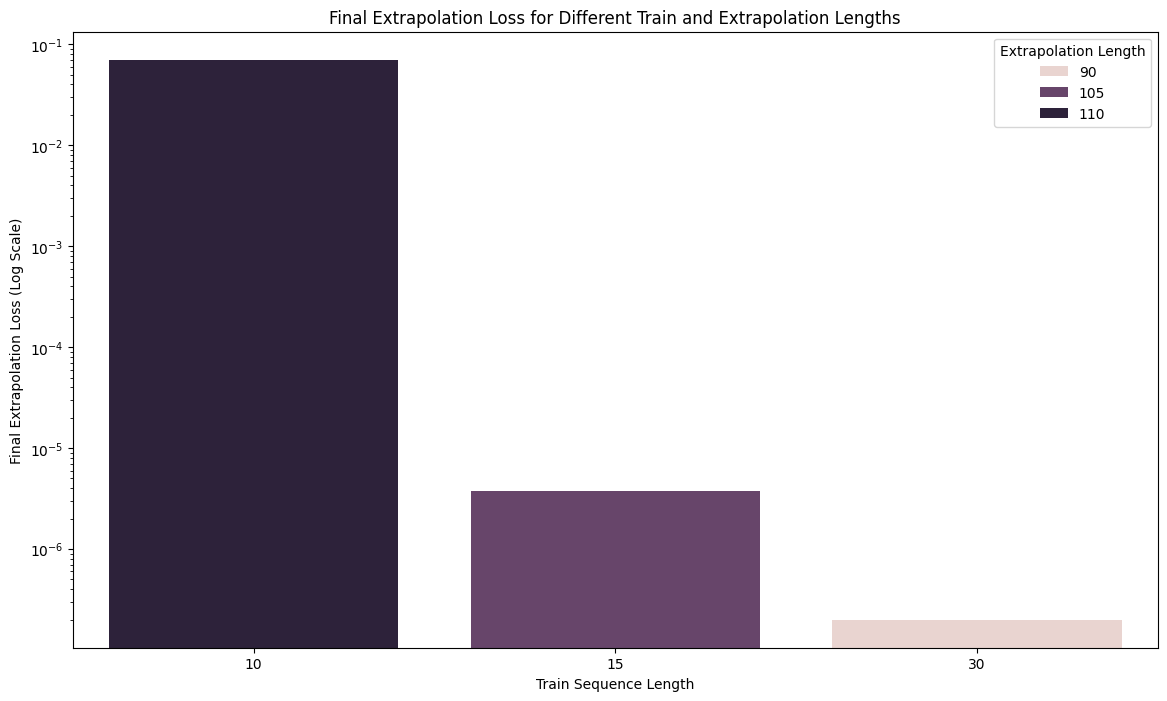

Train Seq Length 10, Extrapolation Length 110:
  Final Train Loss: 9.553e-06
  Final Test Loss: 9.750e-07
  Final Extrapolation Loss: 7.039e-02
Train Seq Length 15, Extrapolation Length 105:
  Final Train Loss: 7.998e-06
  Final Test Loss: 2.959e-07
  Final Extrapolation Loss: 3.775e-06
Train Seq Length 30, Extrapolation Length 90:
  Final Train Loss: 4.920e-06
  Final Test Loss: 9.708e-07
  Final Extrapolation Loss: 1.995e-07


NameError: name 'json' is not defined

In [4]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import json

def oscillator(d, w0, t):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem."""
    assert d < w0
    d, w0 = torch.Tensor([d]), torch.Tensor([w0])
    w = torch.sqrt(w0**2 - d**2)
    phi = torch.arctan(-d/w)
    A = 1/(2*torch.cos(phi))
    cos = torch.cos(phi + w*t)
    exp = torch.exp(-d*t)
    x = exp * 2 * A * cos
    return x

def generate_oscillator_data(seq_length, num_sequences, d, w0):
    t = torch.linspace(0, seq_length / 100, seq_length)
    data = oscillator(d, w0, t).unsqueeze(-1)
    sequences = data.repeat(num_sequences, 1, 1)
    times = t.repeat(num_sequences, 1, 1)
    return sequences, times


def train(config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    performance_data = []

    for train_seq_length in config['train_seq_lengths']:
        extrapolation_length = config['total_seq_length'] - train_seq_length
        
        model = StateSpaceModel(config['state_dim'], config['input_dim'], config['output_dim'], config['kan_layers']).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
        criterion = nn.MSELoss()
        
        train_data, train_times = generate_oscillator_data(config['total_seq_length'], config['num_sequences'], config['d'], config['w0'])
        train_data, train_times = train_data.to(device), train_times.to(device)
        
        train_losses = []
        test_losses = []
        patience_counter = 0
        
        epoch = 0
        while patience_counter < config['patience']:
            model.train()
            optimizer.zero_grad()
            
            state = train_data[:, :train_seq_length-1, :]
            input = train_data[:, 1:train_seq_length, :]
            observation_target = train_data[:, 1:train_seq_length, :]
            
            state = state.reshape(-1, config['state_dim'])
            input = input.reshape(-1, config['input_dim'])
            observation_target = observation_target.reshape(-1, config['output_dim'])
            
            next_state, observation = model(state, input)
            loss = criterion(next_state, state) + criterion(observation, observation_target)
            
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())

            if len(train_losses) > config['n_pts']:
                recent_losses = train_losses[-config['n_pts']:]
                std_recent_losses = np.std(recent_losses)
                if std_recent_losses < config['convergence_std_threshold']:
                    patience_counter += 1
                else:
                    patience_counter = 0
            else:
                patience_counter = 0
            
            model.eval()
            with torch.no_grad():
                test_state = train_data[:, :train_seq_length-1, :]
                test_input = train_data[:, 1:train_seq_length, :]
                
                test_state = test_state.reshape(-1, config['state_dim'])
                test_input = test_input.reshape(-1, config['input_dim'])
                
                _, test_observation = model(test_state, test_input)
                
                extrap_state = train_data[:, train_seq_length-1:-1, :]
                extrap_input = train_data[:, train_seq_length:, :]
                extrap_target = train_data[:, train_seq_length:, :]
                
                extrap_state = extrap_state.reshape(-1, config['state_dim'])
                extrap_input = extrap_input.reshape(-1, config['input_dim'])
                extrap_target = extrap_target.reshape(-1, config['output_dim'])
                
                _, extrap_observation = model(extrap_state, extrap_input)
                
                test_loss = criterion(test_observation, train_data[:, 1:train_seq_length, :].reshape(-1, config['output_dim']))
                extrapolation_loss = criterion(extrap_observation, extrap_target)
                test_losses.append((test_loss.item(), extrapolation_loss.item()))

            if (epoch + 1) % config['log_interval'] == 0:
                print(f"Train Seq Length {train_seq_length}, Extrapolation Length {extrapolation_length}, Epoch {epoch+1}, Train Loss: {loss.item():.3e}, Test Loss: {test_loss.item():.3e}, Extrapolation Loss: {extrapolation_loss.item():.3e}")
            
            epoch += 1
        
        performance_data.append({
            "train_seq_length": train_seq_length,
            "extrapolation_length": extrapolation_length,
            "final_train_loss": train_losses[-1],
            "final_test_loss": test_losses[-1][0],
            "final_extrapolation_loss": test_losses[-1][1]
        })
        
        train_losses = np.array(train_losses)
        test_losses = np.array(test_losses)
        
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label="Train Loss")
        plt.plot(test_losses[:, 0], label="Test Loss")
        plt.plot(test_losses[:, 1], label="Extrapolation Loss")
        plt.yscale('log')
        plt.title(f"Loss Curves for Train Seq Length {train_seq_length}, Extrapolation Length {extrapolation_length}")
        plt.xlabel("Epoch")
        plt.ylabel("Loss (Log Scale)")
        plt.legend()
        plt.show()
        
        exemplar_index = 0
        exemplar_state = train_data[exemplar_index, :train_seq_length-1, :].squeeze().cpu().numpy()
        exemplar_input = train_data[exemplar_index, 1:train_seq_length, :].squeeze().cpu().numpy()
        exemplar_target = train_data[exemplar_index, 1:train_seq_length, :].squeeze().cpu().numpy()
        exemplar_extrapolation = train_data[exemplar_index, train_seq_length:, :].squeeze().cpu().numpy()

        model.eval()
        with torch.no_grad():
            extrap_state = train_data[exemplar_index, train_seq_length-1:-1, :]
            extrap_input = train_data[exemplar_index, train_seq_length:, :]
            
            extrap_state = extrap_state.reshape(-1, config['state_dim'])
            extrap_input = extrap_input.reshape(-1, config['input_dim'])
            
            _, extrap_prediction = model(extrap_state, extrap_input)
            extrap_prediction = extrap_prediction.cpu().numpy().reshape(-1)

        plt.figure(figsize=(12, 6))
        plt.plot(range(train_seq_length - 1), exemplar_state, label="State (Training)", color='blue')
        plt.plot(range(1, train_seq_length), exemplar_input, label="Input (Training)", color='green')
        plt.plot(range(1, train_seq_length), exemplar_target, label="Observation Target (Training)", color='red')
        plt.plot(range(train_seq_length, config['total_seq_length']), exemplar_extrapolation, label="Extrapolation Target", color='orange')
        plt.plot(range(train_seq_length, config['total_seq_length']), extrap_prediction, label="Extrapolation Prediction", color='purple', linestyle='--')
        plt.title(f"Exemplar Training Data for Train Seq Length {train_seq_length}, Extrapolation Length {extrapolation_length}")
        plt.xlabel("Time Step")
        plt.ylabel("Value")
        plt.legend()
        plt.show()
    
    performance_df = pd.DataFrame(performance_data)

    plt.figure(figsize=(14, 8))
    sns.barplot(x="train_seq_length", y="final_train_loss", hue="extrapolation_length", data=performance_df)
    plt.title("Final Train Loss for Different Train and Extrapolation Lengths")
    plt.yscale('log')
    plt.xlabel("Train Sequence Length")
    plt.ylabel("Final Train Loss (Log Scale)")
    plt.legend(title="Extrapolation Length")
    plt.show()

    plt.figure(figsize=(14, 8))
    sns.barplot(x="train_seq_length", y="final_extrapolation_loss", hue="extrapolation_length", data=performance_df)
    plt.title("Final Extrapolation Loss for Different Train and Extrapolation Lengths")
    plt.yscale('log')
    plt.xlabel("Train Sequence Length")
    plt.ylabel("Final Extrapolation Loss (Log Scale)")
    plt.legend(title="Extrapolation Length")
    plt.show()

    for data in performance_data:
        print(f"Train Seq Length {data['train_seq_length']}, Extrapolation Length {data['extrapolation_length']}:")
        print(f"  Final Train Loss: {data['final_train_loss']:.3e}")
        print(f"  Final Test Loss: {data['final_test_loss']:.3e}")
        print(f"  Final Extrapolation Loss: {data['final_extrapolation_loss']:.3e}")

    with open(config['performance_data_file'], "w") as f:
        json.dump(performance_data, f)

config = {
    'state_dim': 1,
    'input_dim': 1,
    'output_dim': 1,
    'kan_layers': [16, 16],
    'batch_size': 10,
    'num_sequences': 10,
    'total_seq_length': 120,
    'train_seq_lengths': [10, 15, 30],
    'convergence_std_threshold': 1e-6,
    'patience': 13,
    'n_pts': 100,
    'd': 4,
    'w0': 40,
    'learning_rate': 1e-3,
    'log_interval': 10,
    'performance_data_file': "performance_data.json"
}

train(config)


In [16]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import time
import json

def oscillator(d, w0, t):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem."""
    assert d < w0
    d, w0 = torch.Tensor([d]), torch.Tensor([w0])
    w = torch.sqrt(w0**2 - d**2)
    phi = torch.arctan(-d/w)
    A = 1/(2*torch.cos(phi))
    cos = torch.cos(phi + w*t)
    exp = torch.exp(-d*t)
    x = exp * 2 * A * cos
    return x

def generate_oscillator_data(seq_length, num_sequences, d, w0, noise_std=0.0):
    t = torch.linspace(0, seq_length / 100, seq_length)
    data = oscillator(d, w0, t).unsqueeze(-1)
    if noise_std > 0:
        noise = noise_std * torch.randn_like(data)
        data += noise
    sequences = data.repeat(num_sequences, 1, 1)
    times = t.repeat(num_sequences, 1, 1)
    return sequences, times

def create_experiment_directory(base_path="experiments"):
    if not os.path.exists(base_path):
        os.makedirs(base_path)
    run_timestamp = str(int(time.time()))
    run_directory = os.path.join(base_path, run_timestamp)
    os.makedirs(run_directory)
    return run_directory

def save_figure(fig, filepath):
    fig.savefig(filepath, bbox_inches='tight')
    plt.close(fig)

def train(config):
    run_directory = create_experiment_directory()
    
    # Save config to the run directory
    with open(os.path.join(run_directory, "config.json"), "w") as config_file:
        json.dump(config, config_file, indent=4)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    performance_data = []

    for train_seq_length in config['train_seq_lengths']:
        validation_length = (config['total_seq_length'] - train_seq_length) // 2
        test_length = config['total_seq_length'] - train_seq_length - validation_length
        
        model = StateSpaceModel(config['state_dim'], config['input_dim'], config['output_dim'], config['kan_layers']).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
        criterion = nn.MSELoss()
        
        # # Generate noisy training data
        # train_data, _ = generate_oscillator_data(train_seq_length, config['num_sequences'], config['d'], config['w0'], noise_std=config['noise_std'])
        # train_data = train_data.to(device)

        # Generate validation data (no noise)
        val_data, _ = generate_oscillator_data(validation_length, config['num_sequences'], config['d'], config['w0'])
        val_data = val_data.to(device)

        # Generate test data (no noise)
        test_data, _ = generate_oscillator_data(test_length, config['num_sequences'], config['d'], config['w0'])
        test_data = test_data.to(device)
        
        train_losses = []
        val_losses = []
        
        epoch = 0
        patience_counter = 0
        while patience_counter < config['patience']:
            model.train()
            optimizer.zero_grad()

            # Generate noisy training data
            train_data, _ = generate_oscillator_data(train_seq_length, config['num_sequences'], config['d'], config['w0'], noise_std=config['noise_std'])
            train_data = train_data.to(device)
            
            state = train_data[:, :train_seq_length-1, :]
            input = train_data[:, 1:train_seq_length, :]
            observation_target = train_data[:, 1:train_seq_length, :]
            
            state = state.reshape(-1, config['state_dim'])
            input = input.reshape(-1, config['input_dim'])
            observation_target = observation_target.reshape(-1, config['output_dim'])
            
            next_state, observation = model(state, input)
            loss = criterion(next_state, state) + criterion(observation, observation_target)
            
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())

            if len(train_losses) > config['n_pts']:
                recent_losses = train_losses[-config['n_pts']:]
                std_recent_losses = np.std(recent_losses)
                if std_recent_losses < config['convergence_std_threshold']:
                    patience_counter += 1
                else:
                    patience_counter = 0
            
            model.eval()
            with torch.no_grad():
                val_state = val_data[:, :validation_length-1, :]
                val_input = val_data[:, 1:validation_length, :]
                
                val_state = val_state.reshape(-1, config['state_dim'])
                val_input = val_input.reshape(-1, config['input_dim'])
                
                _, val_observation = model(val_state, val_input)
                val_loss = criterion(val_observation, val_data[:, 1:validation_length, :].reshape(-1, config['output_dim']))
                val_losses.append(val_loss.item())

            if (epoch + 1) % config['log_interval'] == 0:
                print(f"Train Seq Length {train_seq_length}, Validation Length {validation_length}, Epoch {epoch+1}, Train Loss: {loss.item():.3e}, Val Loss: {val_loss.item():.3e}")
            
            epoch += 1
        
        # Generate final test data
        model.eval()
        with torch.no_grad():
            test_state = test_data[:, :test_length-1, :]
            test_input = test_data[:, 1:test_length, :]
            
            test_state = test_state.reshape(-1, config['state_dim'])
            test_input = test_input.reshape(-1, config['input_dim'])
            
            _, test_observation = model(test_state, test_input)
            test_loss = criterion(test_observation, test_data[:, 1:test_length, :].reshape(-1, config['output_dim']))
        
        performance_data.append({
            "train_seq_length": train_seq_length,
            "validation_length": validation_length,
            "test_length": test_length,
            "final_train_loss": train_losses[-1],
            "final_val_loss": val_losses[-1],
            "final_test_loss": test_loss.item()
        })
        
        train_losses = np.array(train_losses)
        val_losses = np.array(val_losses)
        
        fig = plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label="Train Loss")
        plt.plot(val_losses, label="Validation Loss")
        plt.yscale('log')
        plt.title(f"Loss Curves for Train Seq Length {train_seq_length}, Validation Length {validation_length}")
        plt.xlabel("Epoch")
        plt.ylabel("Loss (Log Scale)")
        plt.legend()
        save_figure(fig, os.path.join(run_directory, f"loss_curves_{train_seq_length}.png"))
    
    performance_df = pd.DataFrame(performance_data)

    fig = plt.figure(figsize=(14, 8))
    sns.barplot(x="train_seq_length", y="final_train_loss", hue="validation_length", data=performance_df)
    plt.title("Final Train Loss for Different Train and Validation Lengths")
    plt.yscale('log')
    plt.xlabel("Train Sequence Length")
    plt.ylabel("Final Train Loss (Log Scale)")
    plt.legend(title="Validation Length")
    save_figure(fig, os.path.join(run_directory, "final_train_loss.png"))

    fig = plt.figure(figsize=(14, 8))
    sns.barplot(x="train_seq_length", y="final_val_loss", hue="validation_length", data=performance_df)
    plt.title("Final Validation Loss for Different Train and Validation Lengths")
    plt.yscale('log')
    plt.xlabel("Train Sequence Length")
    plt.ylabel("Final Validation Loss (Log Scale)")
    plt.legend(title="Validation Length")
    save_figure(fig, os.path.join(run_directory, "final_val_loss.png"))

    fig = plt.figure(figsize=(14, 8))
    sns.barplot(x="train_seq_length", y="final_test_loss", hue="validation_length", data=performance_df)
    plt.title("Final Test Loss for Different Train and Validation Lengths")
    plt.yscale('log')
    plt.xlabel("Train Sequence Length")
    plt.ylabel("Final Test Loss (Log Scale)")
    plt.legend(title="Validation Length")
    save_figure(fig, os.path.join(run_directory, "final_test_loss.png"))

    performance_df.to_csv(os.path.join(run_directory, "performance_data.csv"), index=False)

    with open(os.path.join(run_directory, "performance_data.json"), "w") as f:
        json.dump(performance_data, f)

    # Within the train function, after model evaluation and performance data logging

    # Plot exemplar data for training, validation, and test sets
    exemplar_index = 0

    # Extract data for plotting
    train_example = train_data[exemplar_index, :train_seq_length, :].squeeze().cpu().numpy()
    val_example = val_data[exemplar_index, :validation_length, :].squeeze().cpu().numpy()
    test_example = test_data[exemplar_index, :test_length, :].squeeze().cpu().numpy()

    # Generate time axes for each segment
    train_time = np.linspace(0, train_seq_length / 100, train_seq_length)
    val_time = np.linspace(train_seq_length / 100, (train_seq_length + validation_length) / 100, validation_length)
    test_time = np.linspace((train_seq_length + validation_length) / 100, config['total_seq_length'] / 100, test_length)

    # Combine all sequences and time axes for plotting
    combined_example = np.concatenate((train_example, val_example, test_example), axis=0)
    combined_time = np.concatenate((train_time, val_time, test_time))

    # Model predictions for the entire sequence (training, validation, and test)
    model.eval()
    with torch.no_grad():
        combined_state = torch.cat([train_data[exemplar_index, :train_seq_length-1, :],
                                    val_data[exemplar_index, :validation_length-1, :],
                                    test_data[exemplar_index, :test_length-1, :]], dim=0)
        combined_input = torch.cat([train_data[exemplar_index, 1:train_seq_length, :],
                                    val_data[exemplar_index, 1:validation_length, :],
                                    test_data[exemplar_index, 1:test_length, :]], dim=0)

        combined_state = combined_state.reshape(-1, config['state_dim']).to(device)
        combined_input = combined_input.reshape(-1, config['input_dim']).to(device)
        
        _, combined_prediction = model(combined_state, combined_input)
        combined_prediction = combined_prediction.cpu().numpy().reshape(-1)

    # Adjust combined time axis for predictions (one step ahead)
    combined_time_predictions = np.concatenate((train_time[1:], val_time[1:], test_time[1:]))

    # Plotting the combined data
    fig = plt.figure(figsize=(12, 6))
    plt.plot(combined_time, combined_example, label="True Data", color='blue')
    plt.plot(combined_time_predictions, combined_prediction, label="Model Prediction", color='red', linestyle='--')
    plt.axvline(x=train_seq_length / 100, color='green', linestyle=':', label='End of Training')
    plt.axvline(x=(train_seq_length + validation_length) / 100, color='orange', linestyle=':', label='End of Validation')
    plt.title(f"Training, Validation, and Test Data with Model Prediction")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    save_figure(fig, os.path.join(run_directory, "combined_data_plot.png"))



config = {
    'state_dim': 1,
    'input_dim': 1,
    'output_dim': 1,
    'kan_layers': [16, 16],
    'batch_size': 10,
    'num_sequences': 10,
    'total_seq_length': 120,
    'train_seq_lengths': [10, 15],
    'convergence_std_threshold': 1e-3,
    'patience': 13,
    'n_pts': 100,
    'd': 4,
    'w0': 40,
    'learning_rate': 1e-3,
    'log_interval': 10,
    'noise_std': 0.1  # Standard deviation of noise for training data
}

train(config)


Train Seq Length 10, Validation Length 55, Epoch 10, Train Loss: 7.613e-01, Val Loss: 9.659e-02
Train Seq Length 10, Validation Length 55, Epoch 20, Train Loss: 4.771e-01, Val Loss: 8.832e-02
Train Seq Length 10, Validation Length 55, Epoch 30, Train Loss: 5.999e-01, Val Loss: 7.813e-02
Train Seq Length 10, Validation Length 55, Epoch 40, Train Loss: 3.824e-01, Val Loss: 6.689e-02
Train Seq Length 10, Validation Length 55, Epoch 50, Train Loss: 2.869e-01, Val Loss: 5.582e-02
Train Seq Length 10, Validation Length 55, Epoch 60, Train Loss: 1.750e-01, Val Loss: 4.717e-02
Train Seq Length 10, Validation Length 55, Epoch 70, Train Loss: 4.374e-02, Val Loss: 4.415e-02
Train Seq Length 10, Validation Length 55, Epoch 80, Train Loss: 3.989e-02, Val Loss: 4.755e-02
Train Seq Length 10, Validation Length 55, Epoch 90, Train Loss: 2.109e-02, Val Loss: 4.510e-02
Train Seq Length 10, Validation Length 55, Epoch 100, Train Loss: 1.852e-02, Val Loss: 3.979e-02
Train Seq Length 10, Validation Length 